# Local-Global-Trend(LGT) Example

In [1]:
import pandas as pd
import numpy as np
from orbit.lgt import LGT
from orbit.utils.plot import plot_predicted_data
from orbit.utils.plot import plot_predicted_components

## Data

In [2]:
DATA_FILE = "./data/iclaims.example.csv"

In [3]:
raw_df = pd.read_csv(DATA_FILE, parse_dates=['week'])

In [4]:
raw_df.dtypes

week              datetime64[ns]
claims                     int64
trend.unemploy           float64
trend.filling            float64
trend.job                float64
dtype: object

In [5]:
raw_df.head(5)

,week,claims,trend.unemploy,trend.filling,trend.job
0,2010-01-03,651215,1.183973,0.720140,1.119669
1,2010-01-10,825891,1.183973,0.814896,1.178599
2,2010-01-17,659173,1.203382,0.739091,1.119669
3,2010-01-24,507651,1.164564,0.814896,1.107883
4,2010-01-31,538617,1.086926,0.776993,1.072525


### Train / Test Split

In [6]:
df=raw_df.copy()
test_size=52
train_df=df[:-test_size]
test_df=df[-test_size:]

In [7]:
train_df.head(5)

,week,claims,trend.unemploy,trend.filling,trend.job
0,2010-01-03,651215,1.183973,0.720140,1.119669
1,2010-01-10,825891,1.183973,0.814896,1.178599
2,2010-01-17,659173,1.203382,0.739091,1.119669
3,2010-01-24,507651,1.164564,0.814896,1.107883
4,2010-01-31,538617,1.086926,0.776993,1.072525


## MAP Fit and Predict

In [8]:
lgt_map=LGT(
    response_col="claims",
    date_col="week",
    seasonality=52,
    seed=8888,
    inference_engine='pyro',
    predict_method='map',
    auto_scale=False,
    is_multiplicative=True
)

In [9]:
lgt_map.fit(df=train_df)

step    0 loss = 5864.7
step   10 loss = -122.68
step   20 loss = -440.17
step   30 loss = -510.49
step   40 loss = -528.49
step   50 loss = -527.4
step   60 loss = -538.01
step   70 loss = -531.82
step   80 loss = -543.12
step   90 loss = -531.36
step  100 loss = -544.06


In [10]:
predicted_df = lgt_map.predict(df=test_df)

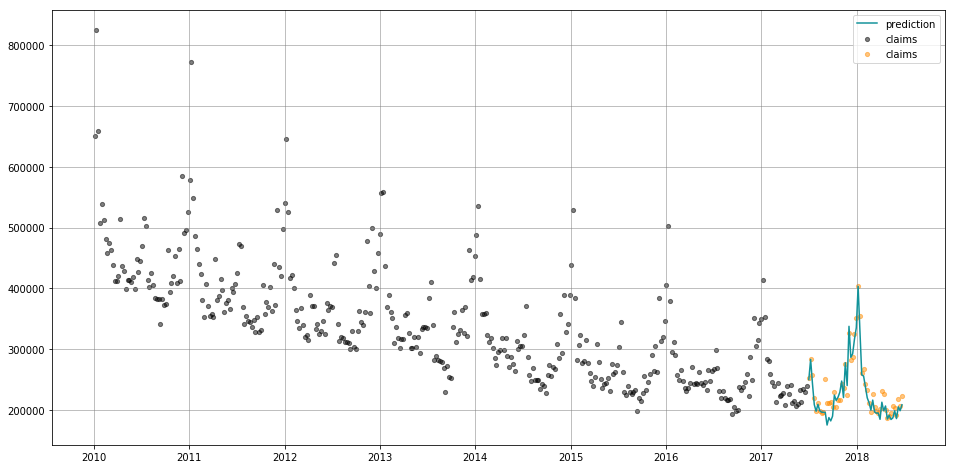

In [11]:
plot_predicted_data(training_actual_df=train_df, predicted_df=predicted_df, 
                    date_col=lgt_map.date_col, actual_col=lgt_map.response_col, pred_col='prediction', 
                    test_actual_df=test_df)

In [12]:
test_df.head(5)

,week,claims,trend.unemploy,trend.filling,trend.job
391,2017-07-02,252886,1.183973,1.099162,0.919307
392,2017-07-09,284329,1.222792,1.023357,1.025381
393,2017-07-16,257763,1.145154,1.061259,0.990023
394,2017-07-23,220455,1.125745,1.023357,1.025381
395,2017-07-30,198776,1.145154,1.042308,1.048953


## SVI Fit and Predict

Pyro uses Stochastic Variational Inference(SVI) for full sampling prediction.

In [13]:
lgt_svi = LGT(
    response_col='claims',
    date_col='week',
    seasonality=52,
    num_warmup=4000, 
    num_sample=500,
    seed=8888,
    inference_engine='pyro',
    predict_method='full',
    n_bootstrap_draws=500
)

In [14]:
lgt_svi.fit(df=train_df)

INFO:root:Guessed max_plate_nesting = 2


step    0 loss = 5936.1, scale = 0.11918
step   10 loss = 51.32, scale = 0.16909
step   20 loss = -51.402, scale = 0.35621
step   30 loss = -291.36, scale = 0.40762
step   40 loss = -367.83, scale = 0.34514
step   50 loss = -394.57, scale = 0.38563
step   60 loss = -409.79, scale = 0.30989
step   70 loss = -416.82, scale = 0.30403
step   80 loss = -418.23, scale = 0.2984
step   90 loss = -419.78, scale = 0.29268
step  100 loss = -419.81, scale = 0.3113


In [15]:
predicted_df = lgt_svi.predict(df=test_df)

In [16]:
predicted_df.tail(5)

,week,5,50,95
47,2018-05-27,174183.397773,208928.539642,254423.317042
48,2018-06-03,164822.595701,196513.669382,239171.319569
49,2018-06-10,179374.518555,217158.291438,259774.302639
50,2018-06-17,176618.311435,208532.493308,255133.585684
51,2018-06-24,182204.355585,220368.770735,268979.208420


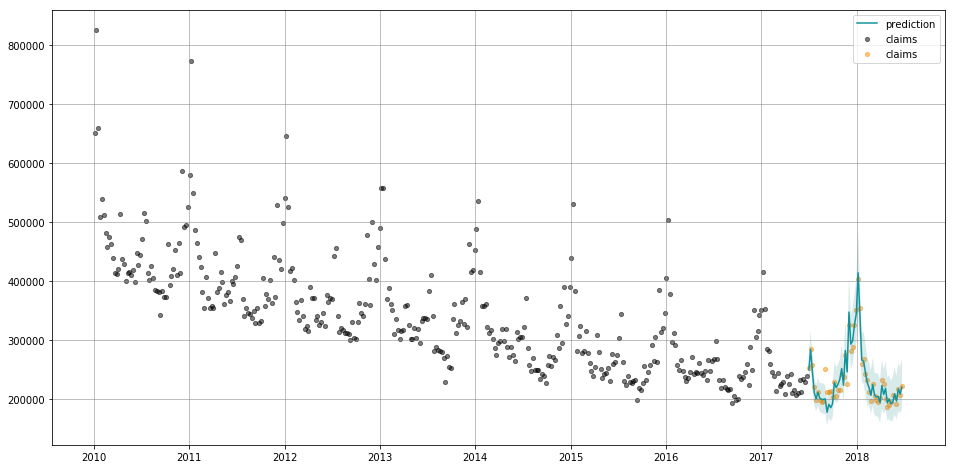

In [17]:
plot_predicted_data(training_actual_df=train_df, predicted_df=predicted_df, 
                    date_col=lgt_svi.date_col, actual_col=lgt_svi.response_col, pred_col=50, 
                    pred_quantiles_col=[5,95], test_actual_df=test_df)

## Mean Fit

In [18]:
lgt_mean=LGT(
    response_col='claims',
    date_col='week',
    seasonality=52,
    seed=8888,
    inference_engine='pyro',
    predict_method='mean'
)

In [19]:
lgt_mean.fit(df=train_df)

INFO:root:Guessed max_plate_nesting = 2


step    0 loss = 5936.1, scale = 0.11918
step   10 loss = 51.32, scale = 0.16909
step   20 loss = -51.402, scale = 0.35621
step   30 loss = -291.36, scale = 0.40762
step   40 loss = -367.83, scale = 0.34514
step   50 loss = -394.57, scale = 0.38563
step   60 loss = -409.79, scale = 0.30989
step   70 loss = -416.82, scale = 0.30403
step   80 loss = -418.23, scale = 0.2984
step   90 loss = -419.78, scale = 0.29268
step  100 loss = -419.81, scale = 0.3113


In [20]:
predicted_df = lgt_mean.predict(df=test_df)

In [21]:
predicted_df.head(5)

,week,prediction
0,2017-07-02,250367.891788
1,2017-07-09,283822.076643
2,2017-07-16,244521.903383
3,2017-07-23,210056.704382
4,2017-07-30,199391.828692


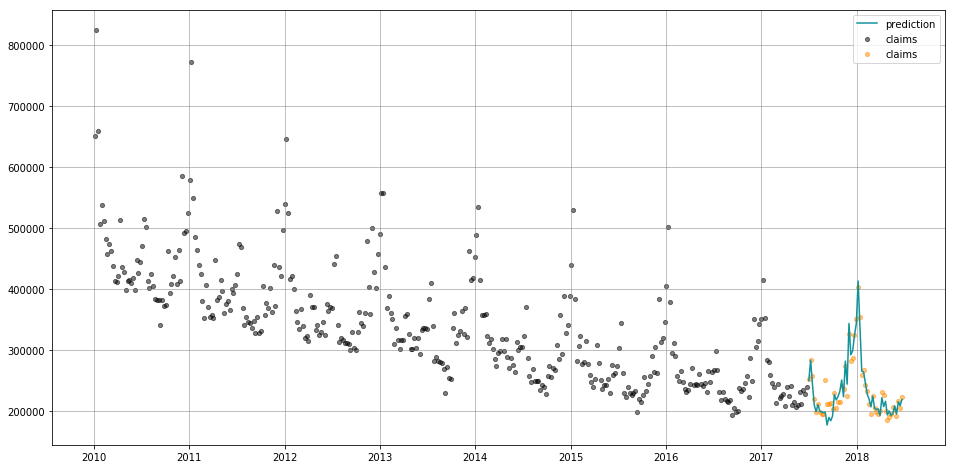

In [22]:
plot_predicted_data(training_actual_df=train_df, predicted_df=predicted_df, 
                    date_col=lgt_mean.date_col, actual_col=lgt_mean.response_col, pred_col='prediction', 
                    test_actual_df=test_df)

## Fit with Regressors [WIP]

In [23]:
lgt_reg_map=LGT(
    response_col='claims',
    regressor_col=['trend.unemploy', 'trend.filling'],
    date_col='week',
    seasonality=52,
    seed=8888,
    inference_engine='pyro',
    predict_method='map'
)

In [24]:
lgt_reg_map.fit(df=train_df)

step    0 loss = 697.76
step   10 loss = -490.69
step   20 loss = -515.67
step   30 loss = -529.9
step   40 loss = -537.31
step   50 loss = -540.78
step   60 loss = -545.1
step   70 loss = -537.54
step   80 loss = -546.42
step   90 loss = -541.4
step  100 loss = -545.42


### Decompose Prediction

We can use `decompose=True` to decompose prediction into `trend`, `seasonality` and `regression` components. This command only works with point estimate.

In [25]:
# make prediction of past and future
predicted_df = lgt_reg_map.predict(df=df, decompose=True)
predicted_df.head(5)

RuntimeError: Expected object of scalar type Double but got scalar type Float for argument #2 'mat2' in call to _th_mm

In [ ]:
plot_predicted_components(predicted_df=predicted_df, date_col='week')